In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip '/content/drive/MyDrive/ADEChallengeData2016.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from keras.models import load_model
model = load_model('/content/drive/MyDrive/semantic_models/unet_checkpoint.h5')
model.compile(optimizer = 'adam', loss = 'sparse_categorical_loss', metrics = ['accuracy'])

from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/semantic_models/cat.jpeg')
test_image = tf.image.resize(test_image,(256,256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model.predict(test_image/255)


1/1 [==============================] - 2s 2s/step


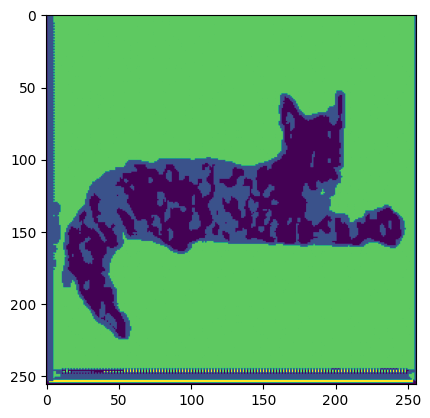

In [ ]:
# value=np.argmax()
# print(np.argmax(result[0,0,0,:],axis=-1))
# print(np.argmax(result[0,125:126,100:101,:],axis=-1))
img=np.argmax(result[0,:,:,:],axis=-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.imshow(img)
# print((np.squeeze(result[:,:5,:5,:]))*255)
# print(img)
# ax.axis('off')
# if 127 in img:
#     print("exist")
# else:
#     print("not exist")

In [ ]:

# Sequential api will not work for skip connections hence functional api
from keras.layers import Lambda
from keras import backend as K
def argmax_layer(input):
  return K.argmax(input, axis=-1)
def finalmask(output,axis):
  return np.argmax(output,axis=axis)
def unet_model(number_of_classes, ImgHeight, ImgWidth):
    # d = layers.Input((ImgHeight, ImgWidth, 3))
    # d11 = layers.Conv2D(filters=1, kernel_size=3, activation='relu', padding='same')(d)
    # d12 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(d11)
    # d13 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(d12)
    # d21 = layers.MaxPooling2D(pool_size=(2, 2))(d13)

    d = layers.Input((ImgHeight,ImgWidth,3))
    d11 = layers.Conv2D(filters=1,kernel_size=3,activation='relu',padding='same')(d)
    d11 = layers.Dropout(0.2)(d11)
    d12 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(d11)
    d13 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(d12)
    d21 = layers.MaxPooling2D(pool_size=(2, 2))(d13)

    d22 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(d21)
    d22 = layers.Dropout(0.2)(d22)
    d23 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(d22)
    d31 = layers.MaxPooling2D(pool_size=(2, 2))(d23)

    d32 = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(d31)
    d32 = layers.Dropout(0.2)(d32)
    d33 = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(d32)
    d41 = layers.MaxPooling2D(pool_size=(2, 2))(d33)

    d42 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(d41)
    d42 = layers.Dropout(0.2)(d42)
    d43 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(d42)
    d51 = layers.MaxPooling2D(pool_size=(2, 2))(d43)

    d52 = layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same')(d51)
    d53 = layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same')(d52)

    u43 = layers.Conv2DTranspose(filters=512, kernel_size=2, strides=2, activation='relu', padding='same')(d53)
    su43 = layers.Concatenate()([d43, u43])
    u42 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(su43)
    u41 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(u42)

    u33 = layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, activation='relu', padding='same')(u41)
    su33 = layers.Concatenate()([d33, u33])
    u32 = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(su33)
    u31 = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(u32)

    u23 = layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, activation='relu', padding='same')(u31)
    su23 = layers.Concatenate()([d23, u23])
    u22 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(su23)
    u21 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(u22)

    u13 = layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, activation='relu', padding='same')(u21)
    su13 = layers.Concatenate()([d13, u13])
    u12 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(su13)
    u11 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(u12)

    outputs = layers.Conv2D(number_of_classes, 1, activation='softmax')(u11)
    # outputs = argmax_layer(outputs)
    model = tf.keras.Model(inputs=d, outputs=outputs)

    return model

In [ ]:
unet=unet_model(151,256,256)
print(unet.summary())

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 1)          28        ['input_2[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 256, 256, 1)          0         ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_21 (Conv2D)          (None, 256, 256, 64)         640       ['dropout_4[0][0]']           
                                                                                            

In [ ]:
from glob import glob
import imageio

def load_data():
  train_x=sorted(glob(os.path.join('/content/ADEChallengeData2016/images/training','*')))
  train_y=sorted(glob(os.path.join('/content/ADEChallengeData2016/annotations/training','*')))

  valid_x=sorted(glob(os.path.join('/content/ADEChallengeData2016/images/validation','*')))
  valid_y=sorted(glob(os.path.join('/content/ADEChallengeData2016/annotations/validation','*')))
  return (train_x,train_y), (valid_x,valid_y)

def preprocess(img_paths,mask_paths):
  img = tf.io.read_file(img_paths)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img,(256,256))

  mask = tf.io.read_file(mask_paths)
  mask = tf.image.decode_png(mask, channels=3)
  # mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.image.resize(mask,(256,256))
  return img, mask

def tf_dataset(x,y,batch=16):
  dataset=tf.data.Dataset.from_tensor_slices((x,y))
  dataset=dataset.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
  dataset=dataset.batch(batch)
  dataset=dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
(train_x,train_y), (valid_x,valid_y)=load_data()
train_dataset=tf_dataset(train_x,train_y,batch=16)
valid_dataset=tf_dataset(valid_x,valid_y,batch=16)
# for i in train_dataset.unbatch():
#   x_train,y_train=next(iter(train_dataset))

# def preprocessmask(mask_paths):
#   mask = tf.io.read_file(mask_paths)
#   mask = tf.image.decode_png(mask, channels=3)
#   # mask = tf.image.convert_image_dtype(mask, tf.float32)
#   mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
#   mask = tf.image.resize(mask,(256,256))
#   return mask
# y_train=tf.data.Dataset.from_tensor_slices(train_y)
# y_train=y_train.map(preprocessmask)
# print(type(y_train))
# print(np.unique(y_train))


callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/unet_checkpoint.h5',verbose=1,save_best_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=False,patience=20)]
model_history = unet.fit(train_dataset, validation_data=valid_dataset, epochs=10, callbacks=callbacks)




Epoch 1/10
1264/1264 [==============================] - ETA: 0s - loss: 3.4072 - accuracy: 0.2037
Epoch 1: val_loss improved from inf to 3.56027, saving model to /content/drive/My Drive/unet_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1264/1264 [==============================] - 1295s 999ms/step - loss: 3.4072 - accuracy: 0.2037 - val_loss: 3.5603 - val_accuracy: 0.1625
Epoch 2/10
1264/1264 [==============================] - ETA: 0s - loss: 3.1773 - accuracy: 0.2436
Epoch 2: val_loss improved from 3.56027 to 3.39793, saving model to /content/drive/My Drive/unet_checkpoint.h5
1264/1264 [==============================] - 1263s 999ms/step - loss: 3.1773 - accuracy: 0.2436 - val_loss: 3.3979 - val_accuracy: 0.1910
Epoch 3/10
1264/1264 [==============================] - ETA: 0s - loss: 3.0907 - accuracy: 0.2622
Epoch 3: val_loss did not improve from 3.39793
1264/1264 [==============================] - 1246s 986ms/step - loss: 3.0907 - accuracy: 0.2622 - val_loss: 3.4157 - val_accuracy: 0.2115
Epoch 4/10
1264/1264 [==============================] - ETA: 0s - loss: 3.0535 - accuracy: 0.2760
Epoch 4: val_loss improved from 3.39793 to 3.36463, saving model to /content/drive/My Drive/unet_checkpoint.h5
1264/1264 [============

In [ ]:
# print(type(train_dataset))
train_dataset.skip(1).take(1)
iterator = iter(train_dataset.skip(4).take(1))
single_image,label = (next(iterator))

# Convert to a NumPy array
image_array = single_image.numpy()
print(image_array.shape)
label=label.numpy()
label=label[0,:,:,:]
imagee_array=image_array[0,:,:,:]
# plt.imshow(imagee_array)
maskimg=unet.predict(image_array)
# plt.imshow(maskimg[0,:,:,:])
# print((train_dataset))
# for x,y in valid_dataset:
#   print(x.shape,y.shape)

fig, axes = plt.subplots(1,  3, figsize=(10, 5))  # Create a figure with two subplots

# Display the first image on the left subplot
axes[0].imshow(imagee_array)
axes[0].set_title('image')  # Set a title for the left subplot

# Display the second image on the right subplot
maskimg=np.argmax(maskimg,axis=-1)
axes[1].imshow(maskimg[0,:,:])
axes[1].set_title('mask')  # Set a title for the right subplot

axes[2].imshow(label)
axes[2].set_title('actual label')

for ax in axes:
    ax.axis('off')  # Turn off axis labels and ticks for both subplots

plt.show()


In [ ]:
# import imageio
# import matplotlib.pyplot as plt
# %matplotlib inline

# path = ''
# image_path = os.path.join(path, '/content/ADEChallengeData2016/images/training/')
# mask_path = os.path.join(path, '/content/ADEChallengeData2016/annotations/training/')
# image_list_orig = os.listdir(image_path)
# mask_list_orig=os.listdir(mask_path)
# # print(image_list_orig)
# # ['ADE_train_00003763.jpg', 'ADE_train_00014989.jpg', 'ADE_train_00009529.jpg......]

# image_list = [image_path+i for i in image_list_orig]

# # print((image_list))
# # ['/content/ADEChallengeData2016/images/trainingADE_train_00003763.jpg', '/content/ADEChallengeData2016/images/trainingADE_train_00014989.jpg',......]

# mask_list = [mask_path+i for i in mask_list_orig]

# # image_list_ds = tf.data.Dataset.list_files(image_list+'*.jpg')
# # mask_list_ds = tf.data.Dataset.list_files(mask_list+'*jpg')

# image_filenames = tf.constant(image_list)
# masks_filenames = tf.constant(mask_list)
# print(image_filenames)
# print(masks_filenames)
# dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
# # N=2
# # img = imageio.imread(image_list[N])
# # mask = imageio.imread(mask_list[N])
# # print(mask_list[N])
# # plt.imshow(img)
# # plt.imshow(mask)
# #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

# def process_path(image_path, mask_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)

#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=3)
#     mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
#     return img, mask

# def preprocess(image, mask):
#     input_image = tf.image.resize(image, (256,256), method='nearest')
#     input_mask = tf.image.resize(mask, (256,256), method='nearest')

#     return input_image, input_mask


# image_ds = dataset.map(process_path)
# processed_image_ds = image_ds.map(preprocess)

# # print(processed_image_ds)
# callbacks=[tf.keras.callbacks.ModelCheckpoint('modelchkpoint.h5',verbose=1,save_best_only=True)]
# EPOCHS = 5
# VAL_SUBSPLITS = 5
# BUFFER_SIZE = 500
# BATCH_SIZE = 32
# X_train = []
# y_train = []

# for image, mask in processed_image_ds:
#     X_train.append(image)
#     y_train.append(mask)

# X_train = tf.concat(X_train, axis=0)
# y_train = tf.concat(y_train, axis=0)

# # train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# # print(processed_image_ds.element_spec)
# model_history = unet.fit(X_train,y_train, epochs=EPOCHS, callbacks=callbacks)

# # for image, mask in image_ds.take(1):
# #     sample_image, sample_mask = image, mask
# #     print(mask.shape)
# # display([sample_image, sample_mask])

# # for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
# #     print(path)

# # Plot images
# # N = 3
# # print(image_list[N])
# # img = imageio.imread(image_list[N])
# # mask = imageio.imread(mask_list[N])
# # # #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

# # fig, arr = plt.subplots(2,1,figsize=(14, 10))
# # arr[0].imshow(img)
# # arr[0].set_title('Image')
# # arr[1].imshow(mask[:, :, 0])
# # arr[1].set_title('Segmentation')
